In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IoB power consumption/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
df.count()

Global_active_power      2049280
Global_reactive_power    2049280
Voltage                  2049280
Global_intensity         2049280
Sub_metering_1           2049280
Sub_metering_2           2049280
Sub_metering_3           2049280
dtype: int64

In [ ]:
values = df.values.astype('float32')
df['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
df['ds']=df.index
df["day_name"]= df['ds'].dt.day_name()
#del df.ds

In [ ]:
df.drop(['ds'], axis=1, inplace=True)

In [ ]:
df.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_name
dt,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670,Saturday
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336,Saturday
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666,Saturday
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800003,Saturday
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.099998,Saturday


In [ ]:
droping_list_all=[]
for j in range(0,9):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
droping_list_all

[0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
for j in range(0,8):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [ ]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
day_name                 0
dtype: int64

In [ ]:
df.count()

Global_active_power      2075259
Global_reactive_power    2075259
Voltage                  2075259
Global_intensity         2075259
Sub_metering_1           2075259
Sub_metering_2           2075259
Sub_metering_3           2075259
sub_metering_4           2075259
day_name                 2075259
dtype: int64

# LSTM

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
df_resample = df.resample('h').sum() 
df_resample.shape

(34589, 8)

In [ ]:
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
dt,,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0,1907.733398
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0,2217.199951
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0,2313.233398
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0,2261.566650
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0,1998.466675


In [ ]:
df_resample["day_name"]= df_resample.index.day_name()
df_resample.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_name
dt,,,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0,1907.733398,Saturday
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0,2217.199951,Saturday


In [ ]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values 

# frame as supervised learning
reframed1 = series_to_supervised(df_resample, 1, 1)

# drop columns we don't want to predict
reframed2= reframed1.drop(reframed1.columns[[7,8,9,10,11,12,13,15,16,17]], axis=1)
reframed2.head()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed2.values)
reframed = pd.DataFrame(scaled, columns=  ["var1(t-1)","var2(t-1)","var3(t-1)","var4(t-1)","var5(t-1)","var6(t-1)","var7(t-1)","var6(t)"])
reframed.head()


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var6(t)
0,0.374384,0.163471,0.000000,0.371473,0.0,0.006820,0.469451,0.144652
1,0.545045,0.088127,0.844110,0.541487,0.0,0.144652,0.782676,0.030869
2,0.509006,0.094957,0.831981,0.502152,0.0,0.030869,0.774169,0.000000
3,0.488550,0.081648,0.839532,0.481110,0.0,0.000000,0.778809,0.008973
4,0.455597,0.083705,0.867315,0.449904,0.0,0.008973,0.798917,0.002872


In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 365*3*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(26280, 1, 7) (26280,) (8308, 1, 7) (8308,)


In [ ]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/20
822/822 - 5s - loss: 0.0074 - val_loss: 0.0049
Epoch 2/20
822/822 - 3s - loss: 0.0072 - val_loss: 0.0049
Epoch 3/20
822/822 - 3s - loss: 0.0072 - val_loss: 0.0049
Epoch 4/20
822/822 - 2s - loss: 0.0072 - val_loss: 0.0048
Epoch 5/20
822/822 - 2s - loss: 0.0071 - val_loss: 0.0048
Epoch 6/20
822/822 - 2s - loss: 0.0071 - val_loss: 0.0048
Epoch 7/20
822/822 - 2s - loss: 0.0071 - val_loss: 0.0048
Epoch 8/20
822/822 - 2s - loss: 0.0071 - val_loss: 0.0048
Epoch 9/20
822/822 - 2s - loss: 0.0071 - val_loss: 0.0048
Epoch 10/20
822/822 - 2s - loss: 0.0070 - val_loss: 0.0048
Epoch 11/20
822/822 - 3s - loss: 0.0070 - val_loss: 0.0048
Epoch 12/20
822/822 - 2s - loss: 0.0070 - val_loss: 0.0048
Epoch 13/20
822/822 - 2s - loss: 0.0070 - val_loss: 0.0048
Epoch 14/20
822/822 - 2s - loss: 0.0070 - val_loss: 0.0048
Epoch 15/20
822/822 - 2s - loss: 0.0070 - val_loss: 0.0048
Epoch 16/20
822/822 - 2s - loss: 0.0070 - val_loss: 0.0048
Epoch 17/20
822/822 - 2s - loss: 0.0070 - val_loss: 0.0048
Epoch 

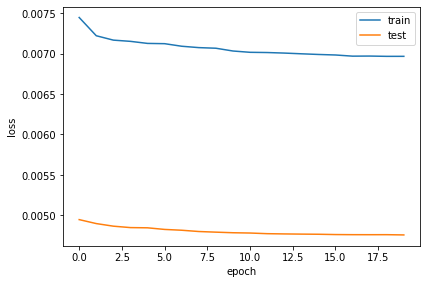

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] =[6.4, 4.4]

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()



In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import mean_absolute_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((test_X[:, -7:],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X[:, -7:],test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 192.184
Test MAE: 68.273


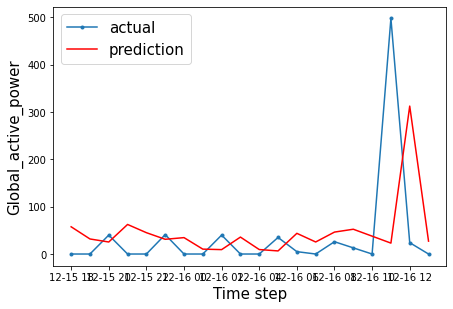

In [ ]:

aa=[x for x in range(20)]
plt.plot(reframed1[n_train_time:n_train_time+20].index, inv_y[:20], marker='.', label="actual")
plt.plot(reframed1[n_train_time:n_train_time+20].index, inv_yhat[:20], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
for_pred = reframed1[n_train_time:n_train_time+500]["var9(t)"].copy().reset_index()
for_pred['Dates'] = pd.to_datetime(for_pred.dt).dt.date
for_pred['Time'] = pd.to_datetime(for_pred.dt).dt.time

for_pred['yhat']= inv_yhat[:500]
for_pred

,dt,var9(t),Dates,Time,yhat
0,2009-12-15 18:00:00,Tuesday,2009-12-15,18:00:00,57.556087
1,2009-12-15 19:00:00,Tuesday,2009-12-15,19:00:00,31.816100
2,2009-12-15 20:00:00,Tuesday,2009-12-15,20:00:00,25.396178
3,2009-12-15 21:00:00,Tuesday,2009-12-15,21:00:00,62.468291
4,2009-12-15 22:00:00,Tuesday,2009-12-15,22:00:00,45.105174
...,...,...,...,...,...
495,2010-01-05 09:00:00,Tuesday,2010-01-05,09:00:00,71.140719
496,2010-01-05 10:00:00,Tuesday,2010-01-05,10:00:00,39.093553
497,2010-01-05 11:00:00,Tuesday,2010-01-05,11:00:00,31.083227
498,2010-01-05 12:00:00,Tuesday,2010-01-05,12:00:00,49.853695


In [ ]:
df_resample['Dates'] = pd.to_datetime(df_resample.index).date
df_resample['Time'] = pd.to_datetime(df_resample.index).time
df_resample

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_name,Dates,Time
dt,,,,,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0,1907.733398,Saturday,2006-12-16,17:00:00
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0,2217.199951,Saturday,2006-12-16,18:00:00
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0,2313.233398,Saturday,2006-12-16,19:00:00
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0,2261.566650,Saturday,2006-12-16,20:00:00
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0,1998.466675,Saturday,2006-12-16,21:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,103.554,3.684,14224.18,433.0,0.0,0.0,772.0,953.899963,Friday,2010-11-26,17:00:00
2010-11-26 18:00:00,94.408,3.222,14251.91,397.2,0.0,0.0,0.0,1573.466675,Friday,2010-11-26,18:00:00
2010-11-26 19:00:00,99.560,3.602,14204.46,423.4,0.0,4.0,0.0,1655.333374,Friday,2010-11-26,19:00:00


In [ ]:
def fun(x):
  return df_resample[(df_resample.index.hour == x[0].hour) & (df_resample.index.month == x[0].month) & (df_resample['day_name']==x[1])].Sub_metering_2.mean() #+ 33.006

for_pred['hour_avg']=for_pred[['dt','var9(t)']].apply(fun,  axis=1)
for_pred

,dt,var9(t),Dates,Time,yhat,hour_avg
0,2009-12-15 18:00:00,Tuesday,2009-12-15,18:00:00,57.556087,66.500000
1,2009-12-15 19:00:00,Tuesday,2009-12-15,19:00:00,31.816100,87.875000
2,2009-12-15 20:00:00,Tuesday,2009-12-15,20:00:00,25.396178,233.062500
3,2009-12-15 21:00:00,Tuesday,2009-12-15,21:00:00,62.468291,186.062500
4,2009-12-15 22:00:00,Tuesday,2009-12-15,22:00:00,45.105174,27.312500
...,...,...,...,...,...,...
495,2010-01-05 09:00:00,Tuesday,2010-01-05,09:00:00,71.140719,8.277778
496,2010-01-05 10:00:00,Tuesday,2010-01-05,10:00:00,39.093553,36.444444
497,2010-01-05 11:00:00,Tuesday,2010-01-05,11:00:00,31.083227,107.722222
498,2010-01-05 12:00:00,Tuesday,2010-01-05,12:00:00,49.853695,317.277778


In [ ]:
for_pred[for_pred['yhat']>for_pred['hour_avg']].count()

dt          235
var9(t)     235
Dates       235
Time        235
yhat        235
hour_avg    235
dtype: int64

In [ ]:
warning = for_pred[for_pred['yhat']>for_pred['hour_avg']].copy()
warning['difference']= warning.yhat - warning.hour_avg
warning.head()

,dt,var9(t),Dates,Time,yhat,hour_avg,difference
4,2009-12-15 22:00:00,Tuesday,2009-12-15,22:00:00,45.105174,27.3125,17.792674
5,2009-12-15 23:00:00,Tuesday,2009-12-15,23:00:00,31.116869,19.6875,11.429369
6,2009-12-16 00:00:00,Wednesday,2009-12-16,00:00:00,34.653231,12.4375,22.215731
9,2009-12-16 03:00:00,Wednesday,2009-12-16,03:00:00,35.791007,15.5000,20.291007
12,2009-12-16 06:00:00,Wednesday,2009-12-16,06:00:00,43.711813,12.9375,30.774313


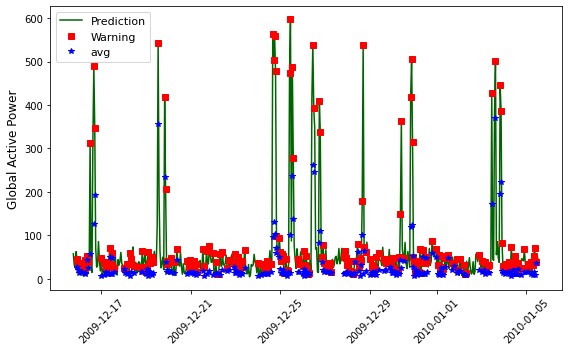

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] =8, 5

aa=[x for x in range(500)]
#plt.plot(reframed1[n_train_time:n_train_time+200].index, inv_y[:500], marker='.',color='b', label="actual")
plt.plot(reframed1[n_train_time:n_train_time+500].index, inv_yhat[:500], color='darkgreen', label="Prediction")
plt.plot(warning.dt, warning.yhat,'s',color='red', label="Warning")
plt.plot(warning.dt, warning.hour_avg,'*',color='blue', label="avg")

plt.xticks(rotation=45)


plt.show()

In [ ]:
warning.difference.sum()

12657.211052863619